In [182]:
from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from typing import List, Set
import numpy as np
import torch
from tqdm import tqdm

In [2]:
Transform = transforms.ToTensor()
data_train = datasets.MNIST(root="mnist", train=True, download=True, transform=Transform)
data_test = datasets.MNIST(root="mnist", train=False, download=True, transform=Transform)

In [3]:
img, y_true = data_train[0]

In [4]:
img.numpy().shape

(1, 28, 28)

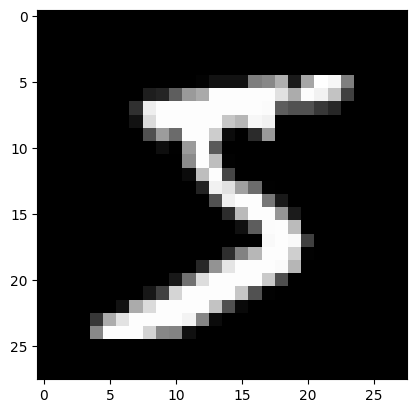

In [5]:
plt.imshow(np.moveaxis(img.numpy(), [0, 1, 2], [2, 0, 1]), cmap="gray")

In [6]:
y_true

5

In [7]:
def make_reduced_dataset(dataset: Dataset, numbers: Set[int]):
    num2idx = {num: idx for idx, num in enumerate(numbers)}
    num_set = set(numbers)
    for img, y_true in dataset:
        if y_true not in num_set:
            continue
        yield num2idx[y_true], img
        

class ReducedMNIST(Dataset):
    def __init__(self):
        self.__imgs = []
        self.__y_true = []
    
    def add(self, y_true, img):
        self.__imgs.append(img)
        self.__y_true.append(y_true)

    def __len__(self):
        return len(self.__y_true)

    def __getitem__(self, idx):
        return self.__imgs[idx], self.__y_true[idx]


In [8]:
train_ldr = DataLoader(data_train, batch_size=100, shuffle=True)
test_ldr = DataLoader(data_test, batch_size=100, shuffle=True)

In [140]:
class Linear:
    def __init__(self, in_features, out_features, learning_rate):
        self.in_features = in_features
        self.out_features = out_features
        self.lr = learning_rate
        self.w = np.random.randn(out_features, in_features)*0.1
        self.b = np.random.randn(out_features, 1)*0.1
        
    def forward(self, X):
        self.inp = X
        shape_x = X.shape
        res = np.dot(self.w, X)
        res = res.flatten()
        res = res.reshape((self.out_features, shape_x[1]))
        self.out = res + self.b
        return self.out

    def adjust_w(self, dw):
        self.w + self.lr * dw
    
    def adjust_b(self, db):
        self.b + self.lr * db
        
    def backward(self, X, y, activation_derivative):
        pass
    
    
class ReLU:
    def forward(self, X):
        X[X <= 0] = 0
        self.out = X
        return X

    def backward(self):
        der = (self.out > 0).astype(int)
        return der

class Sigmoid:
    def forward(self, z):
        res = 1/(1+np.exp(-z))
        self.out = res[0]
        return self.out
    
    def backward(self, y):
        return self.out - y
    

In [141]:
class PyTorchMLP():

    def __init__(self, lr):
        self.layers = [
            Linear(in_features=28*28, out_features=128, learning_rate=lr),
            ReLU(),
            Linear(in_features=128, out_features=84, learning_rate=lr),
            ReLU(),
            Linear(in_features=84, out_features=1, learning_rate=lr),
            Sigmoid()
        ]
        
    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out
    
    def backward(self, y, y_hat):
        # linear layer 3
        error = y_hat - y
        output = self.layers[4].out
        Z = error * self.layers[4].inp
        
        
        
        

In [199]:
train_set = make_reduced_dataset(data_train, (6,9))

In [200]:
net = PyTorchMLP(lr=0.1)

In [201]:

for y, test_input in tqdm(train_set):
    y_hat = net.forward(test_input.flatten().numpy().reshape((784,1)))

    error_prop = y_hat - y
    # linear layer 3
    error = error_prop
    activation = 1
    inp = net.layers[4].inp
    dw = np.dot(np.dot(error, activation), inp.T)
    db = error
    error_prop = np.dot(net.layers[4].w.T , error)
    net.layers[4].adjust_w(dw)
    net.layers[4].adjust_b(db)

    # linear layer 2
    error = error_prop
    activation = net.layers[3].backward()
    inp = net.layers[2].inp
    dw = np.dot(np.dot(error, activation), inp.T)
    db = error
    error_prop = np.dot(net.layers[2].w.T , error)
    net.layers[2].adjust_w(dw)
    net.layers[2].adjust_b(db)

    # linear layer 1
    error = error_prop
    activation = net.layers[1].backward()
    inp = net.layers[0].inp
    dw = np.dot(np.dot(error, activation), inp.T)
    db = error
    error_prop = np.dot(net.layers[0].w.T , error)
    net.layers[0].adjust_w(dw)
    net.layers[0].adjust_b(db)

11867it [00:07, 1521.53it/s]


2

In [205]:
y_hat = []
y_true = []
for i, (y, test_input) in enumerate(make_reduced_dataset(data_train, (6,9))):
    y_hat.append(net.forward(test_input.flatten().numpy().reshape((784,1))))
    y_true.append(y)
    if i >= 100:
        break

In [209]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, np.round(y_hat))

0.33663366336633666